### Импорт

In [1]:
import pandas as pd
import statsmodels.api as sm
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Функции

In [2]:
def delete_outliers (df, column_name): # Функция удаления выбросов из датафрейма методом IRQ
    '''
    Parameters
    ----------
    df: source DataFrame from which outliers are to be removed
    column_name: name of the column to be checked for outliers
    
    Return: Dataframe without outliers in column_name
    '''
    q1=df[column_name].quantile(0.25)
    q3=df[column_name].quantile(0.75)
    d=1.5*(q3-q1)
    lower_bound=q1-d
    upper_bound=q3+d
    print (f"Найдено и удалено {df[(df[column_name]<lower_bound)|(df[column_name]>upper_bound)].shape[0]} выброс(а/ов) в столбце {column_name}")
    return df[(df[column_name]>=lower_bound)&(df[column_name]<=upper_bound)] # включая концы

def chi2_result(a, x, text): 
    cr=ss.chi2_contingency(x) # У этого теста нулевая гипотеза говорит, что между двумя категориальными переменными зависимости нет
    p=cr.pvalue
    f=f"Результат теста Пирсона (Хи-квадрат) о взаимосвязи {text}: statistic={cr.statistic:.3f}, p-value={p:.5f}\n"
    if p<a:
        f+="p-value<alpha -> Существует значимая зависимость\n"
    else:
        f+="p-value>=alpha -> Значимой зависимости нет\n"
    return f

def ttest_result(a, x, y, text):
    tr=ss.ttest_ind(x, y)
    p=tr.pvalue
    f=f"Результат теста на значимость разницы {text}: statistic={tr.statistic:.3f}, p-value={p:.5f}\n"
    if p<a:
        f+="p-value<alpha -> Есть отличия"
    else:
        f+="p-value>=alpha -> Нет отличия"
    return f


def shapiro_result(a, x, text):
    sr=ss.shapiro(x)
    p=sr.pvalue
    f=f"Результат теста с использованием критерия Шапиро-Уилка {text}: statistic={sr.statistic:.3f}, p-value={p:.5f}\n"
    if p<a:
        f+="p-value<alpha -> Распределение не является нормальным\n"
    else:
        f+="p-value>=alpha -> Распределение является нормальным\n"
    return f

def anderson_result(a, x, text):
    a=a*100
    ar=ss.anderson(x)
    s=ar.statistic
    cv=ar.critical_values
    sl=ar.significance_level
    if (a in sl):
        ccv=cv[sl.tolist().index(a)]
        f=f"Результат теста с использованием критерия Андерсона-Дарлинга {text}: statistic={s:.3f}, critical_values={cv}, significance level={sl}\n"
        if (s>ccv):
            f+="Значение статистики превышает критическое значение -> Распределение не является нормальным\n"
        else:
            f+="Значение статистики не превышает критическое значение -> Распределение является нормальным\n"
        return f
    else:
        return f"Не удалось найти критическое значение для уровня значимости {a}%"

def ks_result(a, x, text):
    loc, scale = ss.norm.fit(x) # Определяем параметры распределения
    norm_dist = ss.norm(loc=loc, scale=scale) # Создаем нормальное распределение с данными параметрами
    kr=ss.kstest(x, norm_dist.cdf)
    p=kr.pvalue
    f=f"Результат теста Колмогорова-Смирнова {text}: statistic={kr.statistic:.3f}, p-value={p:.5f}, statistic location={kr.statistic_location:.3f}, statistic sign={kr.statistic_sign:.3f}\n"
    if p<a:
        f+="p-value<alpha -> Распределение не является нормальным\n"
    else:
        f+="p-value>=alpha -> Распределение является нормальным\n"
    return f

def alt_method(x, text): # Дополнительные проверки на нормальность распределения
    mean=x.mean()
    median=x.median()
    d=mean-median
    skew=ss.skew(x)
    kurtosis=ss.kurtosis(x)
    if d!=0:
        cmp="отличается от медианного"
    else:
        cmp_str="равно медианному"
    return f"Среднее значение {text} ({mean:.2f}) {cmp} ({median:.2f}), скошенность: {skew:.2f}, эксцесс:{kurtosis:0.2f}"

### Загружаем данные

Документация - https://vincentarelbundock.github.io/Rdatasets/doc/AER/CollegeDistance.html

In [3]:
item = 'CollegeDistance' # Выбрать из поля Item для вашего датасета
package = 'AER' # Выбрать из поля Package для вашего датасета

df = sm.datasets.get_rdataset(item, package , cache=True).data
df.head()

,gender,ethnicity,score,fcollege,mcollege,home,urban,unemp,wage,distance,tuition,education,income,region
rownames,,,,,,,,,,,,,,
1,male,other,39.150002,yes,no,yes,yes,6.2,8.09,0.2,0.88915,12,high,other
2,female,other,48.869999,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
3,male,other,48.740002,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
4,male,afam,40.400002,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
5,female,other,40.480000,no,no,no,yes,5.6,8.09,0.4,0.88915,13,low,other


### Решение

In [4]:
print (f"Размер датафрейма:\n{df.shape}\n")
print (f"Типы данных в столбцах:\n{df.dtypes}\n")
print (f"Уникальные значения в столбце 'gender':{df['gender'].unique()}") # factor indicating gender
print (f"Уникальные значения в столбце 'gender':{df['ethnicity'].unique()}") # factor indicating ethnicity (African-American, Hispanic or other)
#print (f"Значения в столбце 'score': {mma(df['score'])}\n") # base year composite test score. These are achievement tests given to high school seniors in the sample.
print (f"Уникальные значения в столбце 'fcollege':{df['fcollege'].unique()}") # factor. Is the father a college graduate?
print (f"Уникальные значения в столбце 'mcollege':{df['mcollege'].unique()}") # factor. Is the mother a college graduate?
print (f"Уникальные значения в столбце 'home':{df['home'].unique()}") # factor. Does the family own their home?
print (f"Уникальные значения в столбце 'urban':{df['urban'].unique()}") # factor. Is the school in an urban area?
print (f"Уникальные значения в столбце 'income':{df['income'].unique()}") # factor. Is the family income above USD 25,000 per year?
print (f"Уникальные значения в столбце 'region':{df['region'].unique()}") # factor indicating region (West or other)

print (f"Информация о числовых переменных:\n{df.describe()}\n")
# score - base year composite test score. These are achievement tests given to high school seniors in the sample
# unemp - county unemployment rate in 1980
# wage - state hourly wage in manufacturing in 1980
# distance - distance from 4-year college (in 10 miles)
# tuition - average state 4-year college tuition (in 1000 USD)
# education - number of years of education

Размер датафрейма:
(4739, 14)

Типы данных в столбцах:
gender        object
ethnicity     object
score        float64
fcollege      object
mcollege      object
home          object
urban         object
unemp        float64
wage         float64
distance     float64
tuition      float64
education      int64
income        object
region        object
dtype: object

Уникальные значения в столбце 'gender':['male' 'female']
Уникальные значения в столбце 'gender':['other' 'afam' 'hispanic']
Уникальные значения в столбце 'fcollege':['yes' 'no']
Уникальные значения в столбце 'mcollege':['no' 'yes']
Уникальные значения в столбце 'home':['yes' 'no']
Уникальные значения в столбце 'urban':['yes' 'no']
Уникальные значения в столбце 'income':['high' 'low']
Уникальные значения в столбце 'region':['other' 'west']
Информация о числовых переменных:
             score        unemp         wage     distance      tuition  \
count  4739.000000  4739.000000  4739.000000  4739.000000  4739.000000   
mean     50

Гипотезы:
1. home и income находятся в прямой зависимости, так как семьи с высоким уровнем дохода с большей вероятностью могут себе позволить собственный дом.
2. score и urban находятся в прямой зависимости, так как в городской местности больше возможностей для получения качественного образования.
3. tuition и wage находятся в прямой зависимости, так как большая зарплата - большие издержки -> увеличение стоимости обучения.

In [5]:
#Проверка на дубликаты и их удаление в случае наличия
dups=df.duplicated().sum()
print (f"Найдено {dups} дубликатов")
if dups>0:
    df=df.drop_duplicates()
    print ("Произведено удаление дубликатов")

# Проверка на пропуски
n_miss=df.isna().sum().sum()
print (f"Найдено {n_miss} пропусков")
if n_miss>0: # Удаление пропусков
    df.dropna(inplace=True)
    print("Пропуски были удалены")

# Удаление выбросов из необходимых столбцов
df=delete_outliers(df, 'score')
df=delete_outliers(df, 'tuition')
df=delete_outliers(df, 'wage')

print (f"\nПодготовленный датафрейм:\n{df}")

Найдено 0 дубликатов
Найдено 0 пропусков
Найдено и удалено 0 выброс(а/ов) в столбце score
Найдено и удалено 0 выброс(а/ов) в столбце tuition
Найдено и удалено 272 выброс(а/ов) в столбце wage

Подготовленный датафрейм:
          gender ethnicity      score fcollege mcollege home urban  unemp  \
rownames                                                                    
1           male     other  39.150002      yes       no  yes   yes    6.2   
2         female     other  48.869999       no       no  yes   yes    6.2   
3           male     other  48.740002       no       no  yes   yes    6.2   
4           male      afam  40.400002       no       no  yes   yes    6.2   
5         female     other  40.480000       no       no   no   yes    5.6   
...          ...       ...        ...      ...      ...  ...   ...    ...   
9391        male      afam  56.529999       no       no  yes    no    6.6   
9401        male      afam  59.770000       no       no  yes    no    6.6   
9411        

In [6]:
print (f"Распределение семей, имеющих собственные дома (%):\n{100*df['home'].value_counts(normalize=True)}\n")
print (f"Распределение семей с годовым доходом выше 25 000 $ (%):\n{100*df['income'].value_counts(normalize=True)}\n")
print (f"Распределение школ в городской местности (%):\n{100*df['urban'].value_counts(normalize=True)}\n")
print (f"Описательная статистика для результатов тестирования:\n{ss.describe(df['score'])}\n")
print (f"Описательная статистика для средней стоимости обучения:\n{ss.describe(df['tuition'])}\n")
print (f"Описательная статистика для запрлаты в штате:\n{ss.describe(df['wage'])}\n")

Распределение семей, имеющих собственные дома (%):
home
yes    81.553615
no     18.446385
Name: proportion, dtype: float64

Распределение семей с годовым доходом выше 25 000 $ (%):
income
low     71.815536
high    28.184464
Name: proportion, dtype: float64

Распределение школ в городской местности (%):
urban
no     76.203268
yes    23.796732
Name: proportion, dtype: float64

Описательная статистика для результатов тестирования:
DescribeResult(nobs=4467, minmax=(np.float64(28.950000762939453), np.float64(72.80999755859375)), mean=np.float64(50.82325946593514), variance=np.float64(75.77873693201954), skewness=np.float64(-0.020141876955069762), kurtosis=np.float64(-0.8802259327324085))

Описательная статистика для средней стоимости обучения:
DescribeResult(nobs=4467, minmax=(np.float64(0.2575100064277649), np.float64(1.4041600227355957)), mean=np.float64(0.8030667597078119), variance=np.float64(0.11702450410315614), skewness=np.float64(-0.09840742944854612), kurtosis=np.float64(-1.0538507

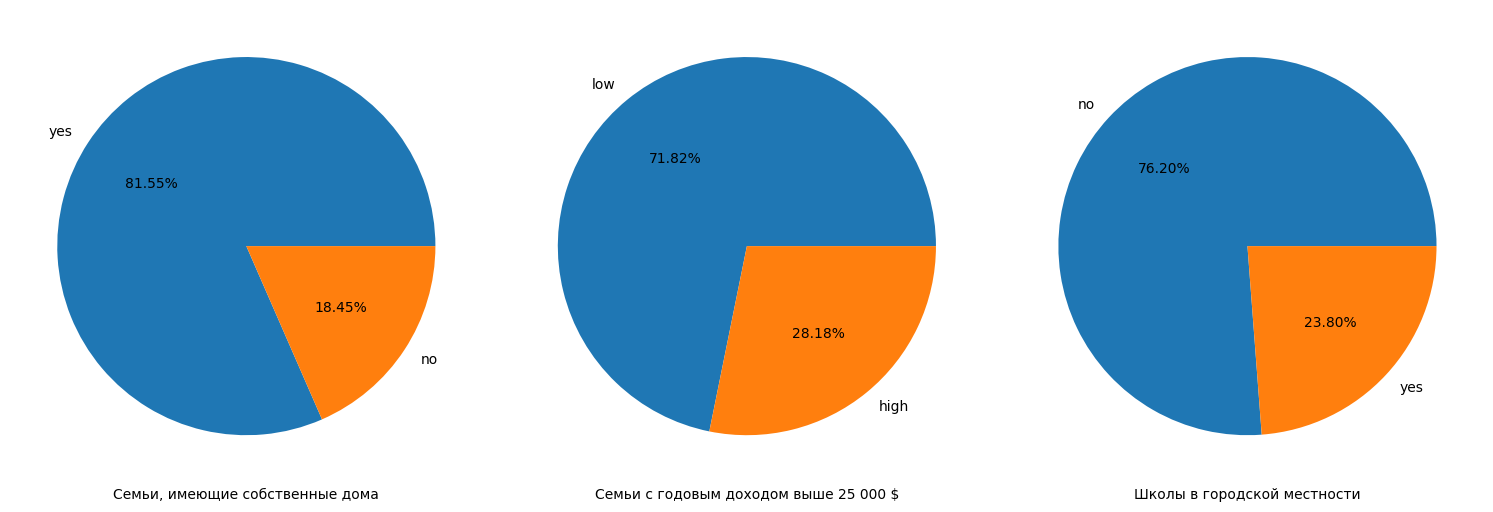

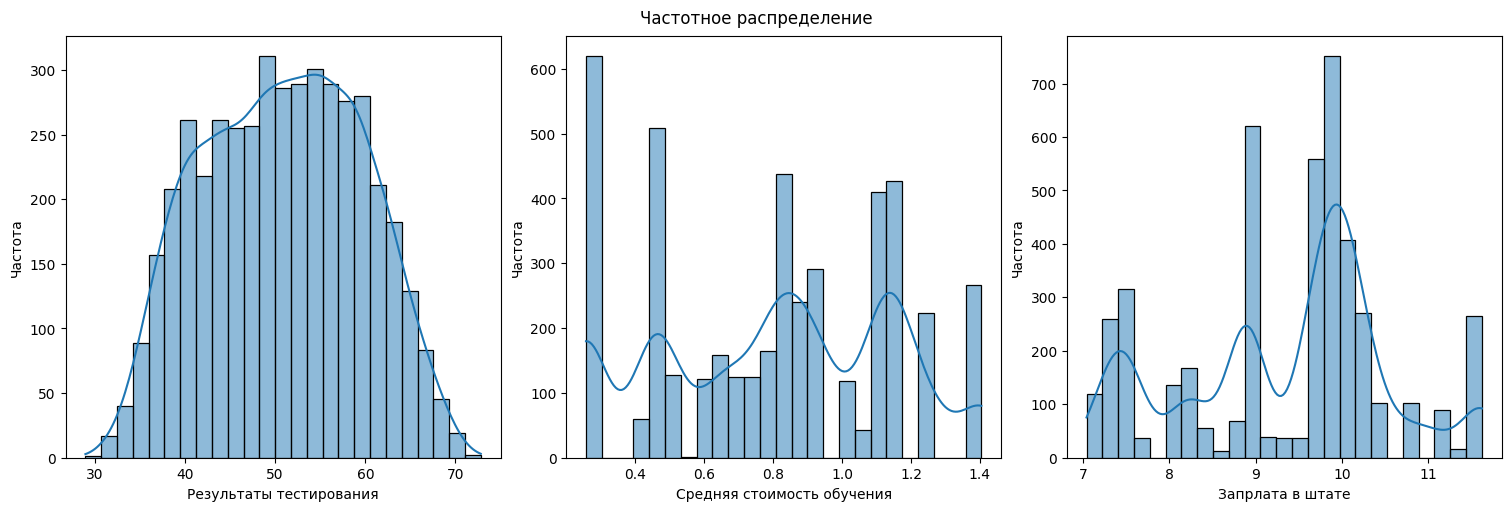

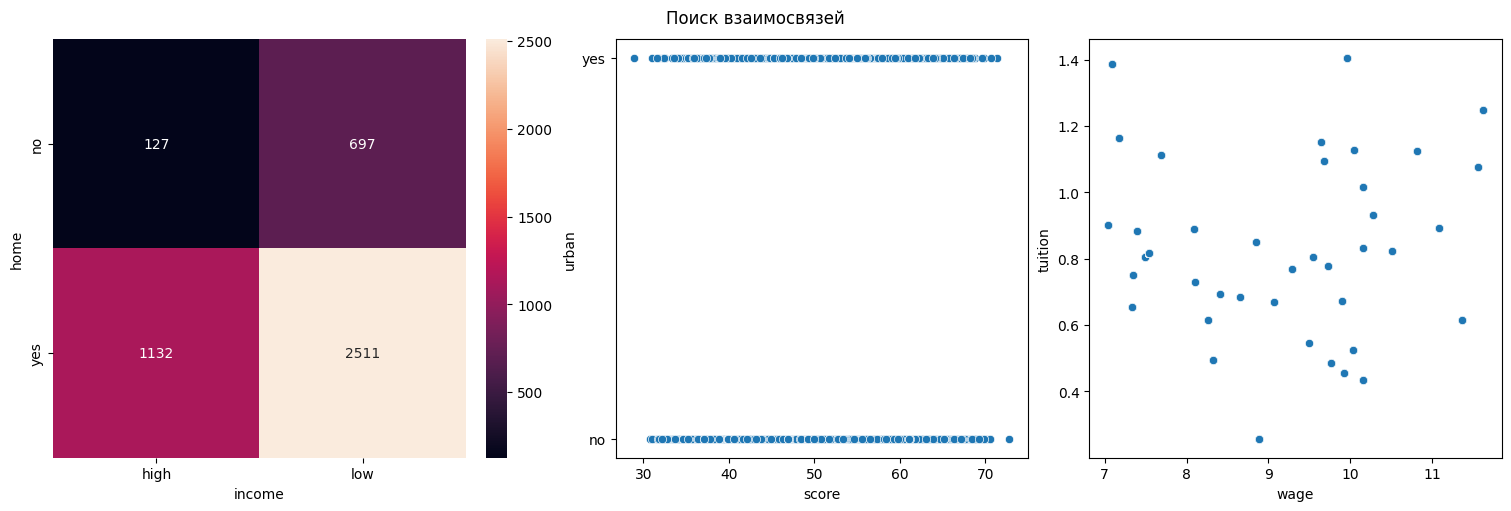

Таблица кросс-табуляции для столбцов 'home' и 'income':
income  high   low
home              
no       127   697
yes     1132  2511


In [7]:
# графики, гистограммы и таблица

fig, ax=plt.subplots(ncols=3, figsize=(15, 5), constrained_layout=True)
ax[0].pie(df['home'].value_counts(normalize=True).values, labels = df['home'].value_counts(normalize=True).index, autopct = '%0.2f%%')
ax[0].set_xlabel('Семьи, имеющие собственные дома')
ax[1].pie(df['income'].value_counts(normalize=True).values, labels = df['income'].value_counts(normalize=True).index, autopct = '%0.2f%%')
ax[1].set_xlabel('Семьи с годовым доходом выше 25 000 $')
ax[2].pie(df['urban'].value_counts(normalize=True).values, labels = df['urban'].value_counts(normalize=True).index, autopct = '%0.2f%%')
ax[2].set_xlabel('Школы в городской местности')
plt.show()

fig, ax=plt.subplots(ncols=3, figsize=(15, 5), constrained_layout=True)
fig.suptitle('Частотное распределение')
sns.histplot(data=df['score'], bins=25, kde=True, ax=ax[0])
sns.histplot(data=df['tuition'], bins=25, kde=True, ax=ax[1])
sns.histplot(data=df['wage'], bins=25, kde=True, ax=ax[2])
ax[0].set_xlabel('Результаты тестирования')
ax[0].set_ylabel('Частота')
ax[1].set_xlabel('Средняя стоимость обучения')
ax[1].set_ylabel('Частота')
ax[2].set_xlabel('Запрлата в штате')
ax[2].set_ylabel('Частота')
plt.show()

df_heatmap=pd.crosstab(df['home'], df['income'])

fig, ax=plt.subplots(ncols=3, figsize=(15, 5), constrained_layout=True)
fig.suptitle('Поиск взаимосвязей')
sns.heatmap(data=df_heatmap, annot=True, fmt='.0f',  ax=ax[0])
sns.scatterplot(data = df, x = 'score', y = 'urban', ax=ax[1])
sns.scatterplot(data = df, x = 'wage', y = 'tuition', ax=ax[2])

plt.show()
print (f"Таблица кросс-табуляции для столбцов 'home' и 'income':\n{df_heatmap}")

Тесты score на нормальность


Уровень доверия: 0.95
Уровень значимости (вероятность ошибки первого рода): 0.05
Визаульный анализ гистограммы для score дает основание сделать вывод о том, что распределение близко к нормальному. Проведем ряд тестов
Результат теста с использованием критерия Шапиро-Уилка для score: statistic=0.983, p-value=0.00000
p-value<alpha -> Распределение не является нормальным

Результат теста с использованием критерия Андерсона-Дарлинга для score: statistic=18.964, critical_values=[0.575 0.655 0.786 0.917 1.091], significance level=[15.  10.   5.   2.5  1. ]
Значение статистики превышает критическое значение -> Распределение не является нормальным

Результат теста Колмогорова-Смирнова для score: statistic=0.042, p-value=0.00000, statistic location=44.160, statistic sign=1.000
p-value<alpha -> Распределение не является нормальным

Все 3 теста отвергают нормальное распределение


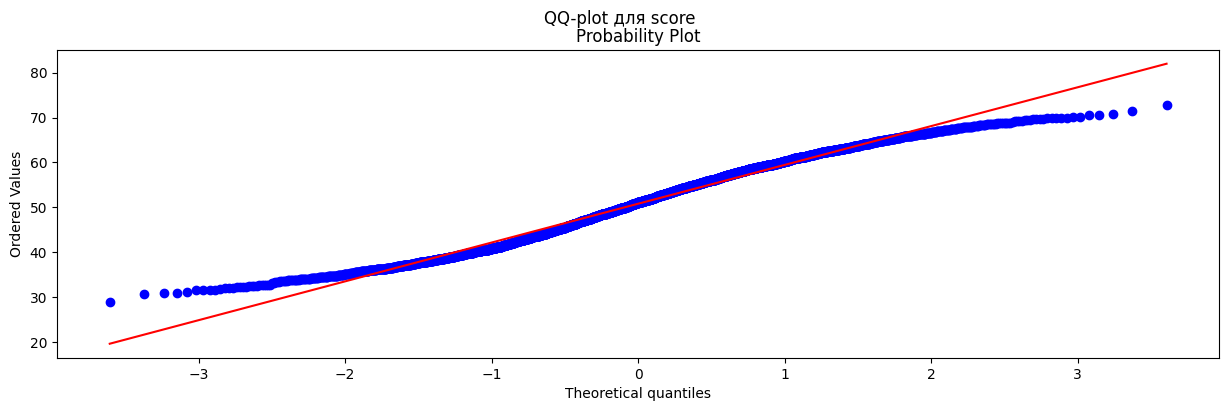

Попробуем перейти к логонормальному распределению


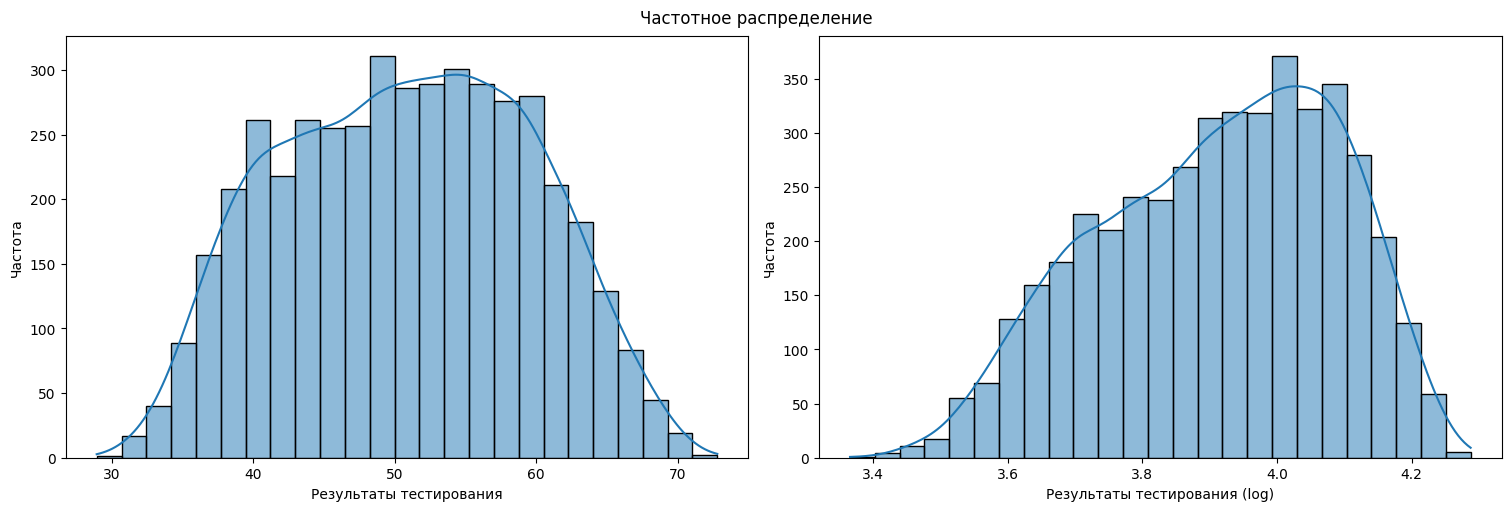

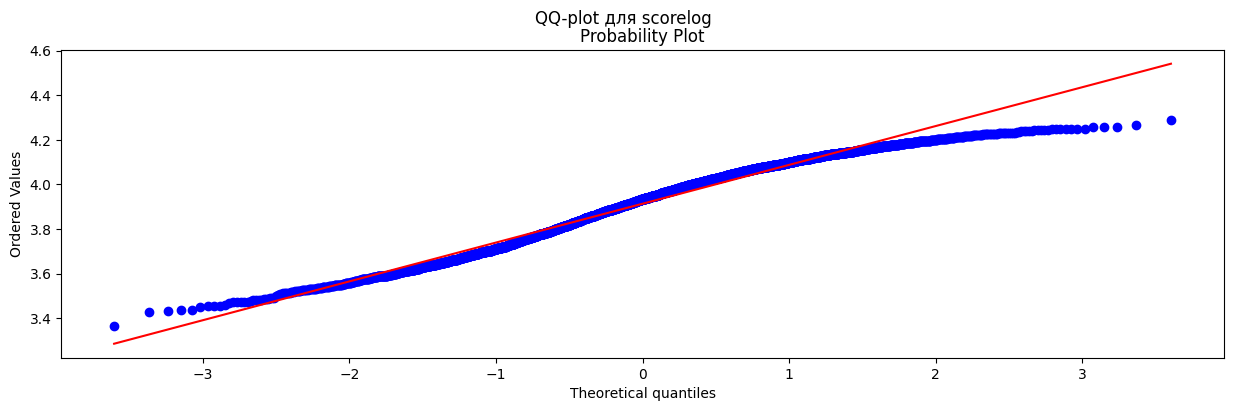

Результат теста с использованием критерия Шапиро-Уилка для scorelog: statistic=0.976, p-value=0.00000
p-value<alpha -> Распределение не является нормальным

Результат теста с использованием критерия Андерсона-Дарлинга для scorelog: statistic=29.924, critical_values=[0.575 0.655 0.786 0.917 1.091], significance level=[15.  10.   5.   2.5  1. ]
Значение статистики превышает критическое значение -> Распределение не является нормальным

Результат теста Колмогорова-Смирнова для scorelog: statistic=0.057, p-value=0.00000, statistic location=3.992, statistic sign=-1.000
p-value<alpha -> Распределение не является нормальным

Тесты и графический анализ отвергают также логонормальное распределение

Применим дополнительные методы
Среднее значение score (50.82) отличается от медианного (51.10), скошенность: -0.02, эксцесс:-0.88
Среднее значение scorelog (3.91) отличается от медианного (3.93), скошенность: -0.32, эксцесс:-0.74


In [8]:
confidence=0.95 # Уровень доверия
print (f"\nУровень доверия: {confidence:.2f}")
alpha=np.round(1-confidence, 2)
print (f"Уровень значимости (вероятность ошибки первого рода): {alpha:.2f}")

print ("Визаульный анализ гистограммы для score дает основание сделать вывод о том, что распределение близко к нормальному. Проведем ряд тестов")
print (shapiro_result(alpha, df['score'], "для score"))
print (anderson_result(alpha, df['score'], "для score"))
print (ks_result(alpha, df['score'], "для score"))
print ("Все 3 теста отвергают нормальное распределение")

fig, ax=plt.subplots(1, 1, figsize=(15, 4))
fig.suptitle('QQ-plot для score')
ss.probplot(df['score'], dist='norm', plot=ax)
plt.show()

print ('Попробуем перейти к логонормальному распределению')
df['scorelog']=df['score'].apply(np.log)

fig, ax=plt.subplots(ncols=2, figsize=(15, 5), constrained_layout=True)
fig.suptitle('Частотное распределение')
sns.histplot(data=df['score'], bins=25, kde=True, ax=ax[0])
sns.histplot(data=df['scorelog'], bins=25, kde=True, ax=ax[1])
ax[0].set_xlabel('Результаты тестирования')
ax[0].set_ylabel('Частота')
ax[1].set_xlabel('Результаты тестирования (log)')
ax[1].set_ylabel('Частота')
plt.show()

fig, ax=plt.subplots(1, 1, figsize=(15, 4))
fig.suptitle('QQ-plot для scorelog')
ss.probplot(df['scorelog'], dist='norm', plot=ax)
plt.show()

print (shapiro_result(alpha, df['scorelog'], "для scorelog"))
print (anderson_result(alpha, df['scorelog'], "для scorelog"))
print (ks_result(alpha, df['scorelog'], "для scorelog"))

print ("Тесты и графический анализ отвергают также логонормальное распределение\n")

print ("Применим дополнительные методы")
print (alt_method(df['score'], "score"))
print (alt_method(df['scorelog'], "scorelog"))

Тестирование гипотез

In [9]:
# home|income
print (chi2_result(alpha, df_heatmap, "между home и income"))

# score|urban
df1=df[df['urban']=='yes']['score'] # городские
df2=df[df['urban']=='no']['score'] # деревенские
print (ttest_result(alpha, df1, df2, "между городскими и деревенскими учащимися"))
print ("Что говорит о существовании взаимосвязи\n")

# wage|tuition
print (f"Корреляция между wage и tuition: {df['wage'].corr(df['tuition']):.2f}")
print ("На вычисленной корреляции заключаем, что взаимосвязь между wage и tuition слабая")
x=sm.add_constant(df['wage'])
model=sm.OLS(df['tuition'], x) # Создание модели линейной регрессии с использованием метода наименьших квадратов
print (f"Результаты оценки линейной регрессии:\n{model.fit().summary()}")
print ("\nИз результатов считываем детерминированную часть уравнения: tuition = 0.0053  + 0.0852 * wage")
print ("Таким образом, так как коэффициент перед wage строго положителен, можем прогнозировать некоторое увеличение tuition при росте wage")

print ("Тесты подвердили сущестование взаимосвязей между переменными, а значит данные датасет может быть использован в дальнейшем для предиктивной аналитики")


Результат теста Пирсона (Хи-квадрат) о взаимосвязи между home и income: statistic=80.654, p-value=0.00000
p-value<alpha -> Существует значимая зависимость

Результат теста на значимость разницы между городскими и деревенскими учащимися: statistic=-5.867, p-value=0.00000
p-value<alpha -> Есть отличия
Что говорит о существовании взаимосвязи

Корреляция между wage и tuition: 0.29
На вычисленной корреляции заключаем, что взаимосвязь между wage и tuition слабая
Результаты оценки линейной регрессии:
                            OLS Regression Results                            
Dep. Variable:                tuition   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     419.7
Date:                Sat, 30 Nov 2024   Prob (F-statistic):           3.17e-89
Time:                        09:49:22   Log-Likelihood:                -1345.5
No. Observations:          